In [125]:
%reset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import colors
import matplotlib.patches as mpatches
from scipy.stats import pearsonr

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [141]:
data_aod = pd.read_csv('20160101_20241231_Amazon_ATTO_Tower.all', skiprows=6, sep = ',')
data_aod['Date_Time'] = pd.to_datetime(data_aod['Date(dd:mm:yyyy)'] + ' ' + data_aod['Time(hh:mm:ss)'], format='%d:%m:%Y %H:%M:%S')
# Extraindo o mês da coluna 'Date_Time'
data_aod['Month'] = data_aod['Date_Time'].dt.month
data_aod['Year'] = data_aod['Date_Time'].dt.year
data_aod_2019_2020 = data_aod#[(data_aod['Year'] == 2020) | (data_aod['Year'] == 2020)].copy()


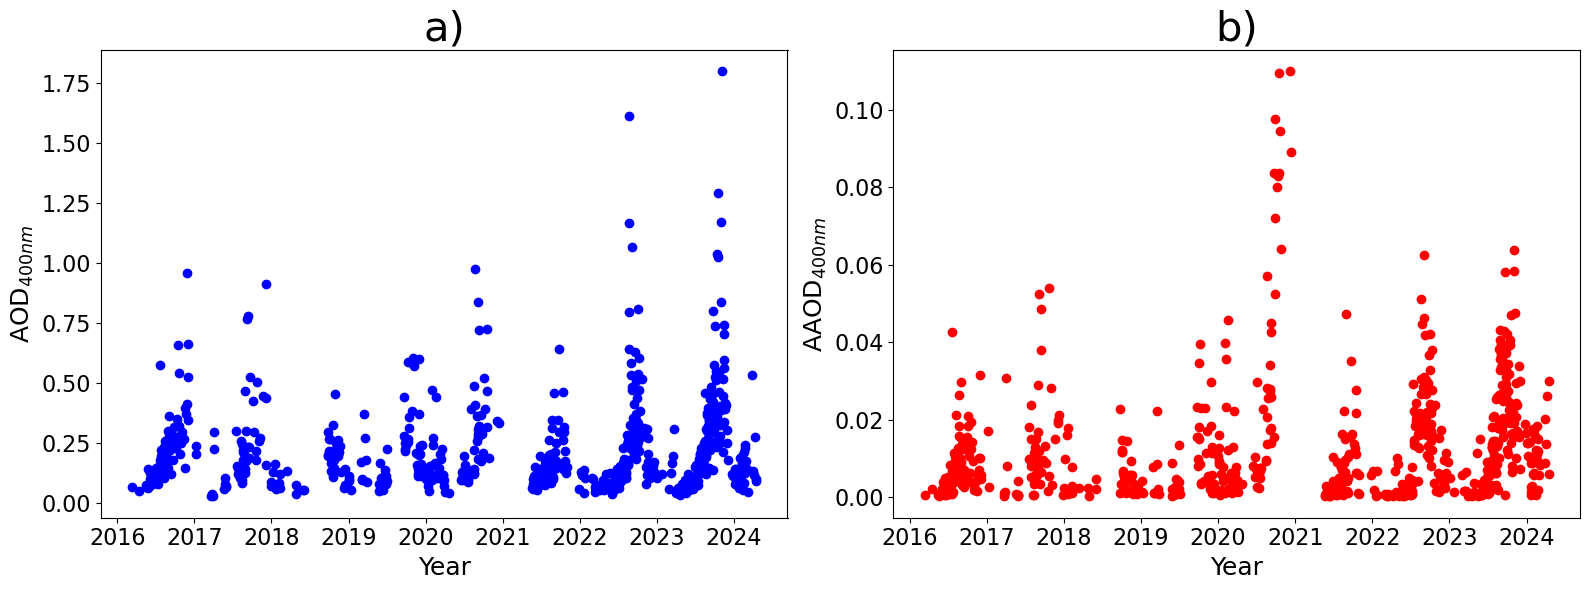

In [197]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(data_aod['Date_Time'], data_aod['AOD_Coincident_Input[440nm]'], color='blue', marker='o', linestyle='')
plt.ylabel('AOD$_{400 nm}$', fontsize=18)
plt.title('a)', fontsize=30)
plt.xlabel('Year', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 2, 2)
plt.plot(data_aod['Date_Time'], data_aod['Absorption_AOD[440nm]'], color='red', marker='o', linestyle='')
plt.ylabel('AAOD$_{400 nm}$', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.title('b)', fontsize=30)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig('AOD_AAOD.pdf')
plt.show()


In [127]:
#Selecting the atmospheric conditions based on Morais et al., 2022 and Palacios et al., 2024

data_dust = data_aod_2019_2020[data_aod_2019_2020['Absorption_Angstrom_Exponent_440-870nm'] > 1.5].copy()

#print(np.mean(data_dust['Refractive_Index-Imaginary_Part[1020nm]']))
#print(np.mean(data_dust['Refractive_Index-Real_Part[1020nm]']))

#Biomass-Burning data

data_bb = data_aod_2019_2020[(data_aod_2019_2020['Absorption_Angstrom_Exponent_440-870nm'] < 1.5) | 
                             (data_aod_2019_2020['Absorption_Angstrom_Exponent_440-870nm'] > 1)].copy()

data_bb = data_bb[data_bb['Angstrom_Exponent_440-870nm_from_Coincident_Input_AOD']>1.5]

#print('')
#print(np.mean(data_bb['Refractive_Index-Imaginary_Part[440nm]']))
#print(np.mean(data_bb['Refractive_Index-Real_Part[440nm]']))

#This conditions comes from Palacios et al., 2024
data_pristine = data_aod_2019_2020[data_aod_2019_2020['AOD_Coincident_Input[440nm]'] <= 0.1].copy()

#print(np.mean(data_pristine['Refractive_Index-Imaginary_Part[1020nm]']))
#print(np.mean(data_pristine['Refractive_Index-Real_Part[1020nm]']))


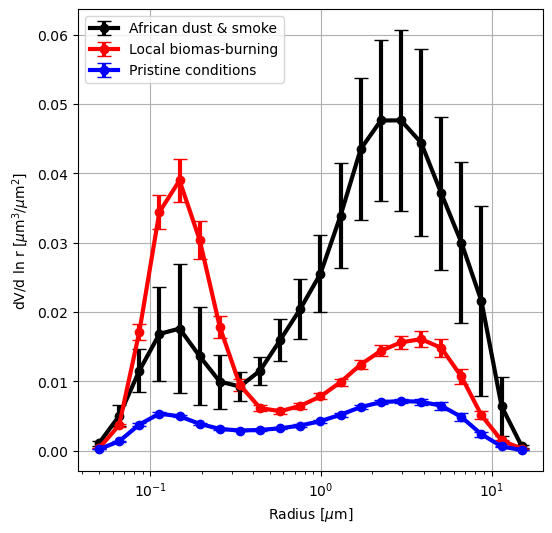

In [129]:
df_selecionado = data_dust
df_selecionado2 = data_bb
df_selecionado3 = data_pristine

def process_data(new_df):
    values = [0.050000, 0.065604, 0.086077, 0.112939, 0.148184, 0.194429, 0.255105, 0.334716, 0.439173, 0.576227, 0.756052, 0.991996, 1.301571, 1.707757, 2.240702, 2.939966, 3.857452, 5.061260, 6.640745, 8.713145, 11.432287, 15.000000]
    selected_columns = []
    for col in new_df.columns:
        try:
            col_float = float(col)
            for value in values:
                if abs(col_float - value) < 0.000001:
                    selected_columns.append(col)
                    break
        except ValueError:
            pass
    return new_df[selected_columns].copy()

def plot_data(x, y, y_error, title, color, label):
    plt.errorbar(x, y, yerr=y_error, fmt='-o', color=color, label=label, linewidth=3, capsize=5)
    plt.xscale('log')
    # plt.yscale('log')  # Opcional: descomente esta linha se quiser escala logarítmica no eixo y
    plt.xlabel('Radius [$\mu$m]')
    plt.ylabel('dV/d ln r [$\mu$m$^3$/$\mu$m$^2$]')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    
def calculate_stats(data):
    mean_values = data.mean(axis=0)
    std_values = data.std(axis=0)
    # Calculate standard error of the mean (SEM) = std / sqrt(n)
    sem_values = std_values / np.sqrt(len(data))
    return mean_values, sem_values
    
values = [0.050000, 0.065604, 0.086077, 0.112939, 0.148184, 0.194429, 0.255105, 0.334716, 0.439173, 0.576227, 0.756052, 0.991996, 1.301571, 1.707757, 2.240702, 2.939966, 3.857452, 5.061260, 6.640745, 8.713145, 11.432287, 15.000000]
    
sd = process_data(df_selecionado)
mean_sd, sem_sd = calculate_stats(sd)

sd2 = process_data(df_selecionado2)
mean_sd2, sem_sd2 = calculate_stats(sd2)

sd3 = process_data(df_selecionado3)
mean_sd3, sem_sd3 = calculate_stats(sd3)

# Extrai os valores da linha específica (índice 0)
plt.figure(figsize=(6, 6))
plot_data(values, mean_sd,sem_sd,'','black','African dust & smoke')
plot_data(values, mean_sd2, sem_sd2,'','red','Local biomas-burning')
plot_data(values, mean_sd3, sem_sd3,'','blue','Pristine conditions')
plt.savefig('size_distr.pdf') 
plt.show()

In [134]:
wavelengths = [440, 675, 870, 1020]

#Dust
Im1 = [calculate_stats(df_selecionado['Refractive_Index-Imaginary_Part[440nm]'])[0],
       calculate_stats(df_selecionado['Refractive_Index-Imaginary_Part[675nm]'])[0],
      calculate_stats(df_selecionado['Refractive_Index-Imaginary_Part[870nm]'])[0],
      calculate_stats(df_selecionado['Refractive_Index-Imaginary_Part[1020nm]'])[0]]
Im1_E = [calculate_stats(df_selecionado['Refractive_Index-Imaginary_Part[440nm]'])[1],
       calculate_stats(df_selecionado['Refractive_Index-Imaginary_Part[675nm]'])[1],
      calculate_stats(df_selecionado['Refractive_Index-Imaginary_Part[870nm]'])[1],
      calculate_stats(df_selecionado['Refractive_Index-Imaginary_Part[1020nm]'])[1]]

Re1 = [calculate_stats(df_selecionado['Refractive_Index-Real_Part[440nm]'])[0],
       calculate_stats(df_selecionado['Refractive_Index-Real_Part[675nm]'])[0],
      calculate_stats(df_selecionado['Refractive_Index-Real_Part[870nm]'])[0],
      calculate_stats(df_selecionado['Refractive_Index-Real_Part[1020nm]'])[0]]
Re1_E = [calculate_stats(df_selecionado['Refractive_Index-Real_Part[440nm]'])[1],
       calculate_stats(df_selecionado['Refractive_Index-Real_Part[675nm]'])[1],
      calculate_stats(df_selecionado['Refractive_Index-Real_Part[870nm]'])[1],
      calculate_stats(df_selecionado['Refractive_Index-Real_Part[1020nm]'])[1]]

#Biomass-Burning
Im2 = [calculate_stats(df_selecionado2['Refractive_Index-Imaginary_Part[440nm]'])[0],
       calculate_stats(df_selecionado2['Refractive_Index-Imaginary_Part[675nm]'])[0],
      calculate_stats(df_selecionado2['Refractive_Index-Imaginary_Part[870nm]'])[0],
      calculate_stats(df_selecionado2['Refractive_Index-Imaginary_Part[1020nm]'])[0]]
Im2_E = [calculate_stats(df_selecionado2['Refractive_Index-Imaginary_Part[440nm]'])[1],
       calculate_stats(df_selecionado2['Refractive_Index-Imaginary_Part[675nm]'])[1],
      calculate_stats(df_selecionado2['Refractive_Index-Imaginary_Part[870nm]'])[1],
      calculate_stats(df_selecionado2['Refractive_Index-Imaginary_Part[1020nm]'])[1]]

Re2 = [calculate_stats(df_selecionado2['Refractive_Index-Real_Part[440nm]'])[0],
       calculate_stats(df_selecionado2['Refractive_Index-Real_Part[675nm]'])[0],
      calculate_stats(df_selecionado2['Refractive_Index-Real_Part[870nm]'])[0],
      calculate_stats(df_selecionado2['Refractive_Index-Real_Part[1020nm]'])[0]]
Re2_E = [calculate_stats(df_selecionado2['Refractive_Index-Real_Part[440nm]'])[1],
       calculate_stats(df_selecionado2['Refractive_Index-Real_Part[675nm]'])[1],
      calculate_stats(df_selecionado2['Refractive_Index-Real_Part[870nm]'])[1],
      calculate_stats(df_selecionado2['Refractive_Index-Real_Part[1020nm]'])[1]]

#Pristine
Im3 = [calculate_stats(df_selecionado3['Refractive_Index-Imaginary_Part[440nm]'])[0],
       calculate_stats(df_selecionado3['Refractive_Index-Imaginary_Part[675nm]'])[0],
      calculate_stats(df_selecionado3['Refractive_Index-Imaginary_Part[870nm]'])[0],
      calculate_stats(df_selecionado3['Refractive_Index-Imaginary_Part[1020nm]'])[0]]
Im3_E = [calculate_stats(df_selecionado3['Refractive_Index-Imaginary_Part[440nm]'])[1],
       calculate_stats(df_selecionado3['Refractive_Index-Imaginary_Part[675nm]'])[1],
      calculate_stats(df_selecionado3['Refractive_Index-Imaginary_Part[870nm]'])[1],
      calculate_stats(df_selecionado3['Refractive_Index-Imaginary_Part[1020nm]'])[1]]

Re3 = [calculate_stats(df_selecionado3['Refractive_Index-Real_Part[440nm]'])[0],
       calculate_stats(df_selecionado3['Refractive_Index-Real_Part[675nm]'])[0],
      calculate_stats(df_selecionado3['Refractive_Index-Real_Part[870nm]'])[0],
      calculate_stats(df_selecionado3['Refractive_Index-Real_Part[1020nm]'])[0]]
Re3_E = [calculate_stats(df_selecionado3['Refractive_Index-Real_Part[440nm]'])[1],
       calculate_stats(df_selecionado3['Refractive_Index-Real_Part[675nm]'])[1],
      calculate_stats(df_selecionado3['Refractive_Index-Real_Part[870nm]'])[1],
      calculate_stats(df_selecionado3['Refractive_Index-Real_Part[1020nm]'])[1]]


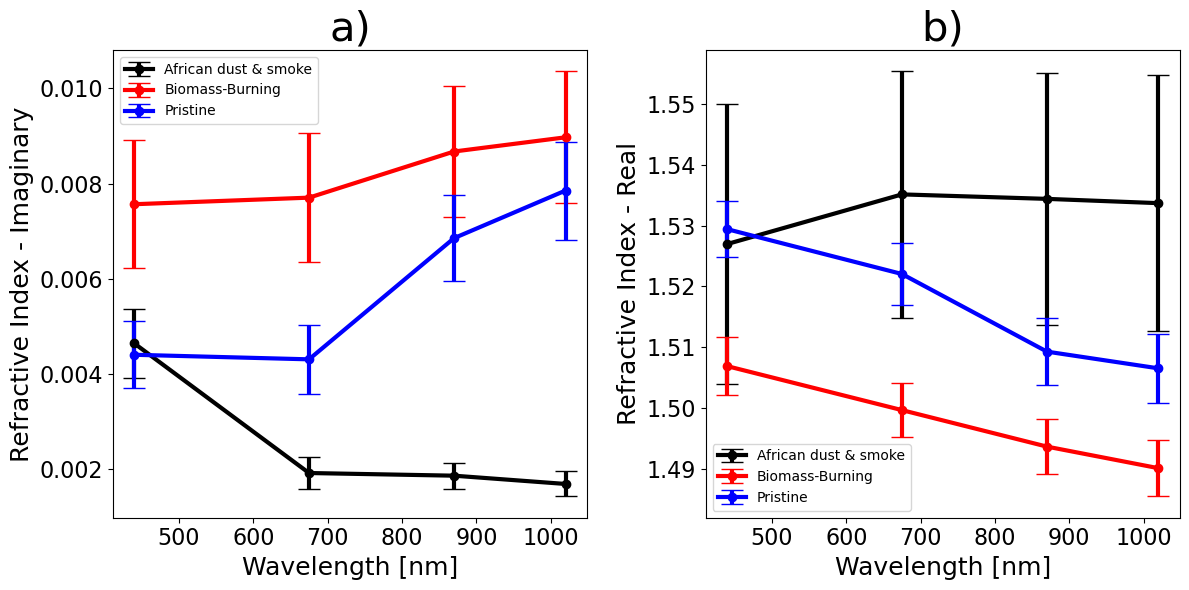

In [226]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Criando um subplot com 2 linhas e 1 coluna
# Plotando os dados da parte imaginária dos índices de refração
axs[0].errorbar(wavelengths, Im1, yerr=Im1_E, fmt='-o', color='black', label='African dust & smoke',linewidth=3, capsize=8)
axs[0].errorbar(wavelengths, Im2, yerr=Im2_E, fmt='-o', color='red', label='Biomass-Burning',linewidth=3, capsize=8)
axs[0].errorbar(wavelengths, Im3, yerr=Im3_E, fmt='-o', color='blue', label='Pristine',linewidth=3, capsize=8)
axs[0].set_ylabel('Refractive Index - Imaginary', fontsize = 18)
axs[0].set_xlabel('Wavelength [nm]', fontsize=18)
axs[0].set_title('a)',fontsize=30)
axs[0].tick_params(axis='both', which='major', labelsize=16) 
axs[0].legend()

axs[1].errorbar(wavelengths, Re1, yerr=Re1_E, fmt='-o', color='black', label='African dust & smoke',linewidth=3, capsize=8)
axs[1].errorbar(wavelengths, Re2, yerr=Re2_E, fmt='-o', color='red', label='Biomass-Burning',linewidth=3, capsize=8)
axs[1].errorbar(wavelengths, Re3, yerr=Re3_E, fmt='-o', color='blue', label='Pristine',linewidth=3, capsize=8)
axs[1].set_ylabel('Refractive Index - Real', fontsize=18)
axs[1].set_xlabel('Wavelength [nm]', fontsize=18)
axs[1].legend()
axs[1].set_title('b)', fontsize=30)
plt.tight_layout()  
axs[1].tick_params(axis='both', which='major', labelsize=16) 

plt.subplots_adjust(wspace=0.25)

plt.savefig('refractive_index.pdf') 
plt.show()


In [200]:
#Dust
AAOD1 = [calculate_stats(df_selecionado['Absorption_AOD[440nm]'])[0],
       calculate_stats(df_selecionado['Absorption_AOD[675nm]'])[0],
      calculate_stats(df_selecionado['Absorption_AOD[870nm]'])[0],
      calculate_stats(df_selecionado['Absorption_AOD[1020nm]'])[0]]
AAOD1_E = [calculate_stats(df_selecionado['Absorption_AOD[440nm]'])[1],
       calculate_stats(df_selecionado['Absorption_AOD[675nm]'])[1],
      calculate_stats(df_selecionado['Absorption_AOD[870nm]'])[1],
      calculate_stats(df_selecionado['Absorption_AOD[1020nm]'])[1]]

AOD1 = [calculate_stats(df_selecionado['AOD_Coincident_Input[440nm]'])[0],
       calculate_stats(df_selecionado['AOD_Coincident_Input[675nm]'])[0],
      calculate_stats(df_selecionado['AOD_Coincident_Input[870nm]'])[0],
      calculate_stats(df_selecionado['AOD_Coincident_Input[1020nm]'])[0]]
AOD1_E = [calculate_stats(df_selecionado['AOD_Coincident_Input[440nm]'])[1],
       calculate_stats(df_selecionado['AOD_Coincident_Input[675nm]'])[1],
      calculate_stats(df_selecionado['AOD_Coincident_Input[870nm]'])[1],
      calculate_stats(df_selecionado['AOD_Coincident_Input[1020nm]'])[1]]

#Biomass-Burning
AAOD2 = [calculate_stats(df_selecionado2['Absorption_AOD[440nm]'])[0],
       calculate_stats(df_selecionado2['Absorption_AOD[675nm]'])[0],
      calculate_stats(df_selecionado2['Absorption_AOD[870nm]'])[0],
      calculate_stats(df_selecionado2['Absorption_AOD[1020nm]'])[0]]
AAOD2_E = [calculate_stats(df_selecionado2['Absorption_AOD[440nm]'])[1],
       calculate_stats(df_selecionado2['Absorption_AOD[675nm]'])[1],
      calculate_stats(df_selecionado2['Absorption_AOD[870nm]'])[1],
      calculate_stats(df_selecionado2['Absorption_AOD[1020nm]'])[1]]

AOD2 = [calculate_stats(df_selecionado2['AOD_Coincident_Input[440nm]'])[0],
       calculate_stats(df_selecionado2['AOD_Coincident_Input[675nm]'])[0],
      calculate_stats(df_selecionado2['AOD_Coincident_Input[870nm]'])[0],
      calculate_stats(df_selecionado2['AOD_Coincident_Input[1020nm]'])[0]]
AOD2_E = [calculate_stats(df_selecionado2['AOD_Coincident_Input[440nm]'])[1],
       calculate_stats(df_selecionado2['AOD_Coincident_Input[675nm]'])[1],
      calculate_stats(df_selecionado2['AOD_Coincident_Input[870nm]'])[1],
      calculate_stats(df_selecionado2['AOD_Coincident_Input[1020nm]'])[1]]

#Pristine
AAOD3 = [calculate_stats(df_selecionado3['Absorption_AOD[440nm]'])[0],
       calculate_stats(df_selecionado3['Absorption_AOD[675nm]'])[0],
      calculate_stats(df_selecionado3['Absorption_AOD[870nm]'])[0],
      calculate_stats(df_selecionado3['Absorption_AOD[1020nm]'])[0]]
AAOD3_E = [calculate_stats(df_selecionado3['Absorption_AOD[440nm]'])[1],
       calculate_stats(df_selecionado3['Absorption_AOD[675nm]'])[1],
      calculate_stats(df_selecionado3['Absorption_AOD[870nm]'])[1],
      calculate_stats(df_selecionado3['Absorption_AOD[1020nm]'])[1]]

AOD3 = [calculate_stats(df_selecionado3['AOD_Coincident_Input[440nm]'])[0],
       calculate_stats(df_selecionado3['AOD_Coincident_Input[675nm]'])[0],
      calculate_stats(df_selecionado3['AOD_Coincident_Input[870nm]'])[0],
      calculate_stats(df_selecionado3['AOD_Coincident_Input[1020nm]'])[0]]
AOD3_E = [calculate_stats(df_selecionado3['AOD_Coincident_Input[440nm]'])[1],
       calculate_stats(df_selecionado3['AOD_Coincident_Input[675nm]'])[1],
      calculate_stats(df_selecionado3['AOD_Coincident_Input[870nm]'])[1],
      calculate_stats(df_selecionado3['AOD_Coincident_Input[1020nm]'])[1]]


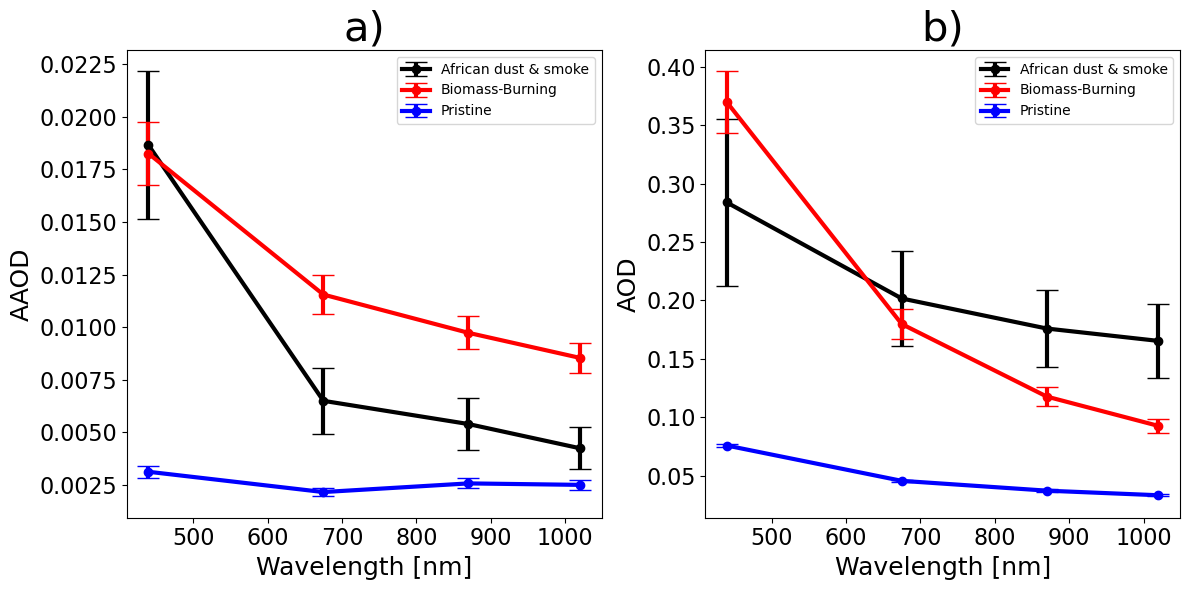

In [231]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Criando um subplot com 2 linhas e 1 coluna

# Plotando os dados da parte AAODaginária dos índices de AODfração
axs[0].errorbar(wavelengths, AAOD1, yerr=AAOD1_E, fmt='-o', color='black', label='African dust & smoke',linewidth=3, capsize=8)
axs[0].errorbar(wavelengths, AAOD2, yerr=AAOD2_E, fmt='-o', color='red', label='Biomass-Burning',linewidth=3, capsize=8)
axs[0].errorbar(wavelengths, AAOD3, yerr=AAOD3_E, fmt='-o', color='blue', label='Pristine',linewidth=3, capsize=8)
axs[0].set_ylabel('AAOD', fontsize = 18)
axs[0].set_xlabel('Wavelength [nm]', fontsize=18)
axs[0].set_title('a)',fontsize=30)
axs[0].tick_params(axis='both', which='major', labelsize=16) 
axs[0].legend()

# Plotando os dados da parte AODal dos índices de AODfração
axs[1].errorbar(wavelengths, AOD1, yerr=AOD1_E, fmt='-o', color='black', label='African dust & smoke',linewidth=3, capsize=8)
axs[1].errorbar(wavelengths, AOD2, yerr=AOD2_E, fmt='-o', color='red', label='Biomass-Burning',linewidth=3, capsize=8)
axs[1].errorbar(wavelengths, AOD3, yerr=AOD3_E, fmt='-o', color='blue', label='Pristine',linewidth=3, capsize=8)
axs[1].set_ylabel('AOD', fontsize = 18)
axs[1].set_xlabel('Wavelength [nm]', fontsize=18)
axs[1].set_title('b)',fontsize=30)
axs[1].tick_params(axis='both', which='major', labelsize=16) 
axs[1].legend()
plt.tight_layout()  # Ajusta automaticamente o espaçamento entAOD os subplots
plt.savefig('periods_AOD_AAOD.pdf') 
plt.show()
